In [ ]:
# default_exp models.TSTPlus

# TSTPlus (Time Series Transformer)

> This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on TST (Zerveas, 2020) and Transformer (Vaswani, 2017).

**References:**

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). [A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.](https://arxiv.org/pdf/2010.02803)
* No official implementation available as far as I know (Oct 10th, 2020)

* Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). [Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)

* He, R., Ravula, A., Kanagal, B., & Ainslie, J. (2020). Realformer: Transformer Likes Informed Attention. arXiv preprint arXiv:2012.11747.

This implementation is adapted to work with the rest of the `tsai` library, and contain some hyperparameters that are not available in the original implementation. I included them for experimenting.

## Tips on how to use transformers:

* In general, transformers require a lower lr compared to other time series models when used with the same datasets. It's important to use `learn.lr_find()` to learn what a good lr may be. In general, I've found lr between 1e-4 to 3e-4 work well.

* The paper authors recommend to standardize data by feature. This can be done by adding `TSStandardize(by_var=True)` as a batch_tfm when creating the `TSDataLoaders`.

* When using TST with a long time series, you may use `max_w_len` to reduce the memory size and thus avoid gpu issues. By default it's set to 512.

* I've tried different types of positional encoders. In my experience, the default one works just fine.

* In some of the cases I've used it, you may need to increase the res_dropout > .1 and/ or fc_dropout > 0 in order to achieve a good performance. 

## Imports

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

## Positional encoders

In [ ]:
#export
def SinCosPosEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model, device=default_device())
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10) 
    return pe.to(device=device)

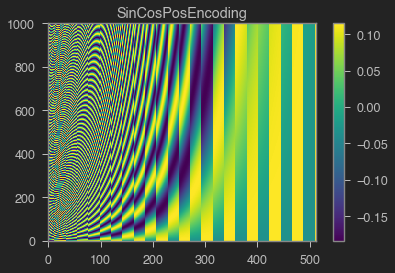

(3.2037498e-10, 0.09999991, -0.18388666, 0.11518021, (1000, 512))

In [ ]:
pe = SinCosPosEncoding(1000, 512).detach().cpu().numpy()
plt.pcolormesh(pe, cmap='viridis')
plt.title('SinCosPosEncoding')
plt.colorbar()
plt.show()
pe.mean(), pe.std(), pe.min(), pe.max(), pe.shape

In [ ]:
#export
def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False, device=default_device()):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10) 
    return cpe.to(device=device)

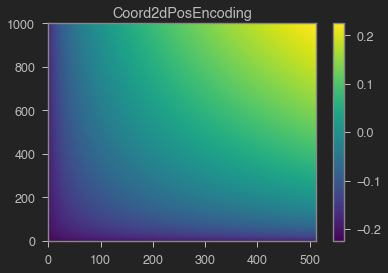

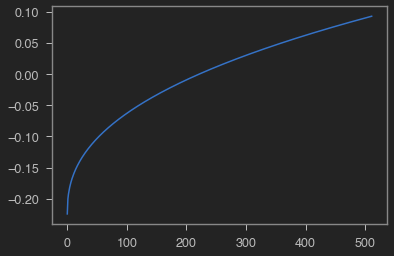

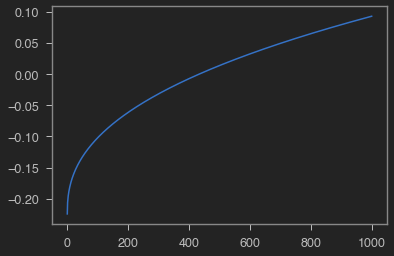

(3.695488e-09, 0.09999991, -0.22459325, 0.22487777)

In [ ]:
cpe = Coord2dPosEncoding(1000, 512, exponential=True, normalize=True).cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord2dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(0))
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max()

In [ ]:
#export
def Coord1dPosEncoding(q_len, exponential=False, normalize=True, device=default_device()):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10) 
    return cpe.to(device=device)

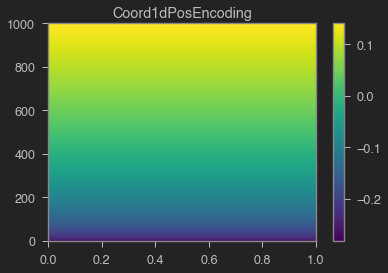

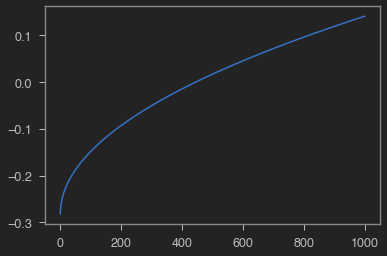

(0.0, 0.099949986, -0.2820423, 0.14113107, (1000, 1))

In [ ]:
cpe = Coord1dPosEncoding(1000, exponential=True, normalize=True).detach().cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord1dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max(), cpe.shape

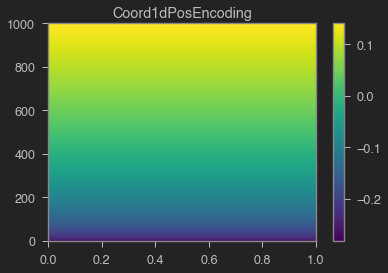

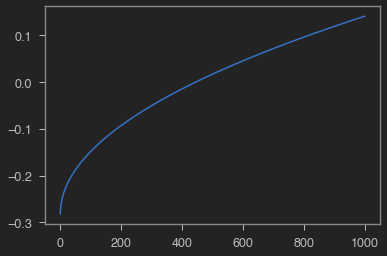

(0.0, 0.099949986, -0.2820423, 0.14113107)

In [ ]:
cpe = Coord1dPosEncoding(1000, exponential=True, normalize=True).detach().cpu().numpy()
plt.pcolormesh(cpe, cmap='viridis')
plt.title('Coord1dPosEncoding')
plt.colorbar()
plt.show()
plt.plot(cpe.mean(1))
plt.show()
cpe.mean(), cpe.std(), cpe.min(), cpe.max()

## TST

In [ ]:
#export
class ScaledDotProductAttention(Module):
    def __init__(self, d_k:int, res_attention:bool=False): self.d_k,self.res_attention = d_k,res_attention
    def forward(self, q:Tensor, k:Tensor, v:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):

        # MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        scores = torch.matmul(q, k)                                    # scores : [bs x n_heads x q_len x q_len]

        # Scale
        scores = scores / (self.d_k ** 0.5)

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x q_len]
            if attn_mask.dtype == torch.bool:
                scores.masked_fill_(attn_mask, float('-inf'))
            else:
                scores += attn_mask
                
        # Key padding mask (optional)
        if key_padding_mask is not None:                                     # key_padding_mask with shape [bs x q_len]
            scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        # SoftMax
        if prev is not None: scores = scores + prev

        attn = F.softmax(scores, dim=-1)                               # attn   : [bs x n_heads x q_len x q_len]

        # MatMul (attn, v)
        context = torch.matmul(attn, v)                                # context: [bs x n_heads x q_len x d_v]

        if self.res_attention: return context, attn, scores
        else: return context, attn

In [ ]:
q = torch.rand([16, 3, 50, 8]) 
k = torch.rand([16, 3, 8, 50]) 
v = torch.rand([16, 3, 50, 6])
attn_mask = torch.triu(torch.ones(50, 50)) # shape: q_len x q_len
key_padding_mask = torch.zeros(16, 50)
key_padding_mask[[1, 3, 6, 15], -10:] = 1
key_padding_mask = key_padding_mask.bool()

In [ ]:
output, attn = ScaledDotProductAttention(d_k=8)(q, k, v, attn_mask=attn_mask, key_padding_mask=key_padding_mask)
output.shape, attn.shape

(torch.Size([16, 3, 50, 6]), torch.Size([16, 3, 50, 50]))

In [ ]:
#export
class MultiHeadAttention(Module):
    def __init__(self, d_model:int, n_heads:int, d_k:int, d_v:int, res_attention:bool=False):
        r"""
        Input shape:  Q, K, V:[batch_size (bs) x q_len x d_model], mask:[q_len x q_len]
        """
        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)

        self.W_O = nn.Linear(n_heads * d_v, d_model, bias=False)

        self.res_attention = res_attention
        
        # Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            self.sdp_attn = ScaledDotProductAttention(self.d_k, self.res_attention)
        else:
            self.sdp_attn = ScaledDotProductAttention(self.d_k)

    def forward(self, Q:Tensor, K:Tensor, V:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):

        bs = Q.size(0)

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]
        print(q_s.shape, k_s.shape, v_s.shape)

        # Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            context, attn, scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            context, attn = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # context: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len]

        # Concat
        context = context.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # context: [bs x q_len x n_heads * d_v]

        # Linear
        output = self.W_O(context)                                                           # context: [bs x q_len x d_model]

        if self.res_attention: return output, attn, scores
        else: return output, attn                                                            # output: [bs x q_len x d_model]


In [ ]:
t = torch.rand(16, 50, 128)
output, attn = MultiHeadAttention(d_model=128, n_heads=3, d_k=8, d_v=6)(t, t, t, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
output.shape, attn.shape

(torch.Size([16, 50, 128]), torch.Size([16, 3, 50, 50]))

In [ ]:
t = torch.rand(16, 50, 128)
att_mask = (torch.rand((50, 50)) > .85).float()
att_mask[att_mask == 1] = -float("Inf")

mha = MultiHeadAttention(d_model=128, n_heads=3, d_k=8, d_v=6)
output, attn = mha(t, t, t, attn_mask=att_mask)
test_eq(torch.isnan(output).sum().item(), 0)
test_eq(torch.isnan(attn).sum().item(), 0)
loss = output[:2, :].sum()
test_eq(torch.isnan(loss).sum().item(), 0)
loss.backward()
for n, p in mha.named_parameters(): test_eq(torch.isnan(p.grad).sum().item(), 0)

In [ ]:
t = torch.rand(16, 50, 128)
attn_mask = (torch.rand((50, 50)) > .85)

# True values will be masked
mha = MultiHeadAttention(d_model=128, n_heads=3, d_k=8, d_v=6)
output, attn = mha(t, t, t, attn_mask=att_mask)
test_eq(torch.isnan(output).sum().item(), 0)
test_eq(torch.isnan(attn).sum().item(), 0)
loss = output[:2, :].sum()
test_eq(torch.isnan(loss).sum().item(), 0)
loss.backward()
for n, p in mha.named_parameters(): test_eq(torch.isnan(p.grad).sum().item(), 0)

In [ ]:
#export
class _TSTEncoderLayer(Module):
    def __init__(self, q_len:int, d_model:int, n_heads:int, d_k:Optional[int]=None, d_v:Optional[int]=None, d_ff:int=256, 
                 res_dropout:float=0.1, bias:bool=True, activation:str="gelu", res_attention:bool=False):

        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = ifnone(d_k, d_model // n_heads)
        d_v = ifnone(d_v, d_model // n_heads)

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = MultiHeadAttention(d_model, n_heads, d_k, d_v, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(res_dropout)
        self.batchnorm_attn = nn.BatchNorm1d(q_len)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias), self._get_activation_fn(activation), nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(res_dropout)
        self.batchnorm_ffn = nn.BatchNorm1d(q_len)

    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        src = self.batchnorm_attn(src) # Norm: batchnorm 

        # Feed-forward sublayer
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        src = self.batchnorm_ffn(src) # Norm: batchnorm

        if self.res_attention:
            return src, scores
        else:
            return src

    def _get_activation_fn(self, activation):
        if callable(activation): return activation()
        elif activation.lower() == "relu": return nn.ReLU()
        elif activation.lower() == "gelu": return nn.GELU()
        raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')

In [ ]:
t = torch.rand(16, 50, 128)
encoder = _TSTEncoderLayer(q_len=50, d_model=128, n_heads=8, d_k=None, d_v=None, d_ff=512, res_dropout=0.1, activation='gelu')
output = encoder(t, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
output.shape

torch.Size([16, 50, 128])

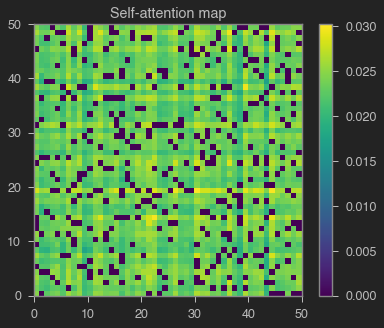

In [ ]:
cmap='viridis'
figsize=(6,5)
plt.figure(figsize=figsize)
plt.pcolormesh(encoder.attn[0][0].detach().cpu().numpy(), cmap=cmap)
plt.title('Self-attention map')
plt.colorbar()
plt.show()

In [ ]:
#export
class _TSTEncoder(Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None, res_dropout=0.1, activation='gelu', res_attention=False, n_layers=1):
        self.layers = nn.ModuleList([_TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, 
                                                      activation=activation, res_attention=res_attention) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:Tensor, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output

In [ ]:
#hide
# class TSTPlus(Module):
#     def __init__(self, c_in:int, c_out:int, seq_len:int, max_seq_len:Optional[int]=512,
#                  n_layers:int=3, d_model:int=128, n_heads:int=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
#                  d_ff:int=256, res_dropout:float=0.1, act:str="gelu", res_attention:bool=True,
#                  pe:str='zeros', learn_pe:bool=True, flatten:bool=True, fc_dropout:float=0., 
#                  concat_pool:bool=True, bn:bool=False, custom_head:Optional=None,
#                  y_range:Optional[tuple]=None, verbose:bool=False, **kwargs):
#         r"""TST (Time Series Transformer) is a Transformer that takes continuous time series as inputs.
#         As mentioned in the paper, the input must be standardized by_var based on the entire training set.
#         Args:
#             c_in: the number of features (aka variables, dimensions, channels) in the time series dataset.
#             c_out: the number of target classes.
#             seq_len: number of time steps in the time series.
#             max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default=512.
#             d_model: total dimension of the model (number of features created by the model)
#             n_heads:  parallel attention heads.
#             d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
#             d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
#             d_ff: the dimension of the feedforward network model.
#             res_dropout: amount of residual dropout applied in the encoder.
#             act: the activation function of intermediate layer, relu or gelu.
#             res_attention: if True Residual MultiHeadAttention is applied.
#             num_layers: the number of sub-encoder-layers in the encoder.
#             pe: type of positional encoder. 
#                 Available types (for experimenting): None, 'exp1d', 'lin1d', 'exp2d', 'lin2d', 'sincos', 'gauss' or 'normal', 
#                 'uniform', 'zero', 'zeros' (default, as in the paper).
#             learn_pe: learned positional encoder (True, default) or fixed positional encoder.
#             flatten: this will flatten the encoder output to be able to apply an mlp type of head (default=True)
#             fc_dropout: dropout applied to the final fully connected layer.
#             concat_pool: indicates whether global adaptive concat pooling will be used instead of global adaptive pooling.
#             bn: indicates if batchnorm will be applied to the head.
#             custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function)
#             y_range: range of possible y values (used in regression tasks).
#             kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

#         Input shape:
#             x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
#             attn_mask: q_len x q_len
#         """
#         self.c_out, self.seq_len = c_out, seq_len

#         # Input encoding
#         q_len = seq_len
#         self.new_q_len = False
#         if max_seq_len is not None and seq_len > max_seq_len: # Control temporal resolution
#             self.new_q_len = True
#             q_len = max_seq_len
#             tr_factor = math.ceil(seq_len / q_len)
#             total_padding = (tr_factor * q_len - seq_len)
#             padding = (total_padding // 2, total_padding - total_padding // 2)
#             self.W_P = nn.Sequential(Pad1d(padding), Conv1d(c_in, d_model, kernel_size=tr_factor, stride=tr_factor))
#             pv(f'temporal resolution modified: {seq_len} --> {q_len} time steps: kernel_size={tr_factor}, stride={tr_factor}, padding={padding}.\n', verbose)
#         elif kwargs:
#             self.new_q_len = True
#             t = torch.rand(1, 1, seq_len)
#             q_len = Conv1d(1, 1, **kwargs)(t).shape[-1]
#             self.W_P = Conv1d(c_in, d_model, **kwargs) # Eq 2
#             pv(f'Conv1d with kwargs={kwargs} applied to input to create input encodings\n', verbose)
#         else:
#             self.W_P = nn.Linear(c_in, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space

#         # Positional encoding
#         if pe == None:
#             W_pos = torch.zeros((q_len, d_model), device=default_device()) # pe = None and learn_pe = False can be used to measure impact of pe
#             learn_pe = False
#         elif pe == 'zero': W_pos = torch.zeros((q_len, 1), device=default_device())
#         elif pe == 'zeros': W_pos = torch.zeros((q_len, d_model), device=default_device())
#         elif pe == 'normal' or pe == 'gauss': 
#             W_pos = torch.zeros((q_len, 1), device=default_device())
#             torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
#         elif pe == 'uniform': 
#             W_pos = torch.zeros((q_len, 1), device=default_device())
#             nn.init.uniform_(W_pos, a=0.0, b=0.1)
#         elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
#         elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
#         elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
#         elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
#         elif pe == 'sincos': W_pos = SinCosPosEncoding(q_len, d_model, normalize=True)
#         else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
#             'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
#         self.W_pos = nn.Parameter(W_pos, requires_grad=learn_pe)

#         # Residual dropout
#         self.res_dropout = nn.Dropout(res_dropout)

#         # Encoder
#         encoder_layer = TSTEncoderLayer(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=act,
#                                         res_attention=res_attention)
#         self.encoder = TSTEncoder(encoder_layer, n_layers, res_attention=res_attention)
#         self.transpose = Transpose(-1, -2, contiguous=True)

#         # Head
#         self.head_nf = d_model
#         self.c_out = c_out
#         self.seq_len = q_len
#         if custom_head: self.head = custom_head(self.head_nf, c_out, q_len) # custom head passed as a partial func with all its kwargs
#         else: self.head = self.create_head(self.head_nf, c_out, q_len, flatten=flatten, concat_pool=concat_pool, fc_dropout=fc_dropout, bn=bn, y_range=y_range)


#     def create_head(self, nf, c_out, seq_len, flatten=True, concat_pool=False, fc_dropout=0., bn=False, y_range=None):
#         if flatten:
#             nf *= seq_len
#             layers = [Flatten()]
#         else:
#             if concat_pool: nf *= 2
#             layers = [GACP1d(1) if concat_pool else GAP1d(1)]
#         layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
#         if y_range: layers += [SigmoidRange(*y_range)]
#         return nn.Sequential(*layers)


#     def forward(self, x:Tensor, attn_mask:Optional[Tensor]=None) -> Tensor:  # x: [bs x nvars x q_len], attn_mask: [q_len x q_len]

#         # Input encoding
#         if self.new_q_len: u = self.W_P(x).transpose(2,1) # Eq 2        # u: [bs x d_model x q_len] transposed to [bs x q_len x d_model]
#         else: u = self.W_P(x.transpose(2,1))              # Eq 1        # u: [bs x q_len x d_model] transposed to [bs x q_len x d_model]

#         # Positional encoding
#         u = self.res_dropout(u + self.W_pos)

#         # Encoder
#         z = self.encoder(u, attn_mask=attn_mask)                        # z: [bs x q_len x d_model]
#         z = self.transpose(z)                                           # z: [bs x d_model x q_len]

#         # Classification/ Regression head
#         return self.head(z)

#     def show_pe(self, cmap='viridis', figsize=None):
#         plt.figure(figsize=figsize)
#         plt.pcolormesh(self.W_pos.detach().cpu().T, cmap=cmap)
#         plt.title('Positional Encoding')
#         plt.colorbar()
#         plt.show()
#         plt.figure(figsize=figsize)
#         plt.title('Positional Encoding - value along time axis')
#         plt.plot(F.relu(self.W_pos.data).mean(1).cpu())
#         plt.plot(-F.relu(-self.W_pos.data).mean(1).cpu())
#         plt.show()

In [ ]:
#export
class _TSTBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, max_seq_len:Optional[int]=512,
                 n_layers:int=3, d_model:int=128, n_heads:int=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, res_dropout:float=0.1, act:str="gelu", 
                 key_padding_mask:bool=True, attn_mask:Optional[Tensor]=None, res_attention:bool=True,
                 pe:str='zeros', learn_pe:bool=True, verbose:bool=False, **kwargs):
    
        # Input encoding
        q_len = seq_len
        self.new_q_len = False
        if max_seq_len is not None and seq_len > max_seq_len: # Control temporal resolution
            self.new_q_len = True
            q_len = max_seq_len
            tr_factor = math.ceil(seq_len / q_len)
            total_padding = (tr_factor * q_len - seq_len)
            padding = (total_padding // 2, total_padding - total_padding // 2)
            self.W_P = nn.Sequential(Pad1d(padding), Conv1d(c_in, d_model, kernel_size=tr_factor, stride=tr_factor))
            pv(f'temporal resolution modified: {seq_len} --> {q_len} time steps: kernel_size={tr_factor}, stride={tr_factor}, padding={padding}.\n', verbose)
        elif kwargs:
            self.new_q_len = True
            t = torch.rand(1, 1, seq_len)
            q_len = Conv1d(1, 1, **kwargs)(t).shape[-1]
            self.W_P = Conv1d(c_in, d_model, **kwargs) # Eq 2
            pv(f'Conv1d with kwargs={kwargs} applied to input to create input encodings\n', verbose)
        else:
            self.W_P = nn.Linear(c_in, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        if pe == None:
            W_pos = torch.zeros((q_len, d_model), device=default_device()) # pe = None and learn_pe = False can be used to measure impact of pe
            learn_pe = False
        elif pe == 'zero': W_pos = torch.zeros((q_len, 1), device=default_device())
        elif pe == 'zeros': W_pos = torch.zeros((q_len, d_model), device=default_device())
        elif pe == 'normal' or pe == 'gauss': 
            W_pos = torch.zeros((q_len, 1), device=default_device())
            torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
        elif pe == 'uniform': 
            W_pos = torch.zeros((q_len, 1), device=default_device())
            nn.init.uniform_(W_pos, a=0.0, b=0.1)
        elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
        elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
        elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
        elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
        elif pe == 'sincos': W_pos = SinCosPosEncoding(q_len, d_model, normalize=True)
        else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
            'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
        self.W_pos = nn.Parameter(W_pos, requires_grad=learn_pe)

        # Residual dropout
        self.res_dropout = nn.Dropout(res_dropout)

        # Encoder
        self.encoder = _TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout,
                                   activation=act, res_attention=res_attention, n_layers=n_layers)
        self.transpose = Transpose(-1, -2, contiguous=True)
        self.key_padding_mask = key_padding_mask
        self.attn_mask = attn_mask
    
    def forward(self, x:Tensor) -> Tensor:  
        # x: [bs x nvars x q_len]
        if self.key_padding_mask and torch.isnan(x).any():
            key_padding_mask = TSMask(torch.isnan(x).float().mean(1).bool())   # key_padding_mask: [bs x q_len]
        else: 
            key_padding_mask = None

        # Input encoding
        if self.new_q_len: u = self.W_P(x).transpose(2,1) # Eq 2        # u: [bs x d_model x q_len] transposed to [bs x q_len x d_model]
        else: u = self.W_P(x.transpose(2,1))              # Eq 1        # u: [bs x q_len x nvars] converted to [bs x q_len x d_model]

        # Positional encoding
        u = self.res_dropout(u + self.W_pos)

        # Encoder
        z = self.encoder(u, key_padding_mask=key_padding_mask, attn_mask=self.attn_mask)    # z: [bs x q_len x d_model]
        z = self.transpose(z)                                                               # z: [bs x d_model x q_len]
        
        return z
    
    
class TSTPlus(nn.Sequential):
    def __init__(self, c_in:int, c_out:int, seq_len:int, max_seq_len:Optional[int]=512,
                 n_layers:int=3, d_model:int=128, n_heads:int=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, res_dropout:float=0.1, act:str="gelu", key_padding_mask:bool=True, attn_mask:Optional[Tensor]=None, 
                 res_attention:bool=False, pe:str='zeros', learn_pe:bool=True, flatten:bool=True, fc_dropout:float=0., 
                 concat_pool:bool=True, bn:bool=False, custom_head:Optional=None,
                 y_range:Optional[tuple]=None, verbose:bool=False, **kwargs):
        r"""TST (Time Series Transformer) is a Transformer that takes continuous time series as inputs.
        As mentioned in the paper, the input must be standardized by_var based on the entire training set.
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset.
            c_out: the number of target classes.
            seq_len: number of time steps in the time series.
            max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default=512.
            d_model: total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
            n_heads:  parallel attention heads. Default:16 (range(8-16)).
            d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_ff: the dimension of the feedforward network model. Default: 512 (range(256-512))
            res_dropout: amount of residual dropout applied in the encoder.
            act: the activation function of intermediate layer, relu or gelu.
            key_padding_mask: a padding mask will be applied to attention if True to those steps in a sample where all features are nan.
            attn_mask: a mask will be applied to attention if a tensor of shape [min(seq_len, max_seq_len) x min(seq_len, max_seq_len)] if provided.
            res_attention: if True Residual MultiHeadAttention is applied.
            num_layers: number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
            pe: type of positional encoder. 
                Available types (for experimenting): None, 'exp1d', 'lin1d', 'exp2d', 'lin2d', 'sincos', 'gauss' or 'normal', 
                'uniform', 'zero', 'zeros' (default, as in the paper).
            learn_pe: learned positional encoder (True, default) or fixed positional encoder.
            flatten: this will flatten the encoder output to be able to apply an mlp type of head (default=True)
            fc_dropout: dropout applied to the final fully connected layer.
            concat_pool: indicates whether global adaptive concat pooling will be used instead of global adaptive pooling.
            bn: indicates if batchnorm will be applied to the head.
            custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function)
            y_range: range of possible y values (used in regression tasks).
            kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

        Input shape:
            x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
            attn_mask: q_len x q_len
        """
        # Backbone
        backbone = _TSTBackbone(c_in, seq_len=seq_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v,
                                d_ff=d_ff, res_dropout=res_dropout, act=act, key_padding_mask=key_padding_mask, attn_mask=attn_mask, 
                                res_attention=res_attention, pe=pe, learn_pe=learn_pe, verbose=verbose, **kwargs)
        
        # Head
        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = backbone.seq_len
        if custom_head: head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else: head = self.create_head(self.head_nf, c_out, self.seq_len, flatten=flatten, concat_pool=concat_pool, 
                                           fc_dropout=fc_dropout, bn=bn, y_range=y_range)
        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))

            
    def create_head(self, nf, c_out, seq_len, flatten=True, concat_pool=False, fc_dropout=0., bn=False, y_range=None):
        if flatten:
            nf *= seq_len
            layers = [Flatten()]
        else:
            if concat_pool: nf *= 2
            layers = [GACP1d(1) if concat_pool else GAP1d(1)]
        layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)
    

    def show_pe(self, cmap='viridis', figsize=None):
        plt.figure(figsize=figsize)
        plt.pcolormesh(self.backbone.W_pos.detach().cpu().T, cmap=cmap)
        plt.title('Positional Encoding')
        plt.colorbar()
        plt.show()
        plt.figure(figsize=figsize)
        plt.title('Positional Encoding - value along time axis')
        plt.plot(F.relu(self.backbone.W_pos.data).mean(1).cpu())
        plt.plot(-F.relu(-self.backbone.W_pos.data).mean(1).cpu())
        plt.show()

In [ ]:
from tsai.models.utils import build_ts_model

bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 1_500

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 256
d_model = 128
n_heads = 16
d_k = d_v = None  # if None --> d_model // n_heads
d_ff = 256
res_dropout = 0.1
activation = "gelu"
n_layers = 3
fc_dropout = 0.1
pe = None
learn_pe = True
kwargs = {}

model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
                d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=activation, n_layers=n_layers,
                fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs)
test_eq(model(xb).shape, [bs, c_out])
test_eq(model[0], model.backbone)
test_eq(model[1], model.head)
model2 = build_ts_model(TSTPlus, c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
                           d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=activation, n_layers=n_layers,
                           fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs)
test_eq(model2(xb).shape, [bs, c_out])
test_eq(model2[0], model2.backbone)
test_eq(model2[1], model2.head)
print(f'model parameters: {count_parameters(model)}')

torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
torch.Size([8, 16, 256, 8]) torch.Size([8, 16, 8, 256]) torch.Size([8, 16, 256, 8])
model parameters: 470018


In [ ]:
from tsai.models.TST import TST
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 150
test_eq(count_parameters(TSTPlus(c_in, c_out, seq_len)), count_parameters(TST(c_in, c_out, seq_len)))

In [ ]:
bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 5000

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

model = TSTPlus(c_in, c_out, seq_len, res_attention=True)
test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 608770


In [ ]:
custom_head = partial(create_pool_head, concat_pool=True)
model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=activation, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, flatten=False, custom_head=custom_head, **kwargs)
test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 421122


In [ ]:
custom_head = partial(create_pool_plus_head, concat_pool=True)
model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=activation, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, flatten=False, custom_head=custom_head, **kwargs)
test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 554240


In [ ]:
bs = 8
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 60

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 120
d_model = 128
n_heads = 16
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
res_dropout = 0.1
act = "gelu"
n_layers = 3
fc_dropout = 0.1
pe='zeros'
learn_pe=True
kwargs = {}
# kwargs = dict(kernel_size=5, padding=2)

model = TSTPlus(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, act=act, n_layers=n_layers,
            fc_dropout=fc_dropout, pe=pe, learn_pe=learn_pe, **kwargs)
test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')
body, head = model[0], model[1]
test_eq(body(xb).ndim, 3)
test_eq(head(body(xb)).ndim, 2)
head

model parameters: 419410


Sequential(
  (0): Flatten(full=False)
  (1): LinBnDrop(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=7680, out_features=2, bias=True)
  )
)

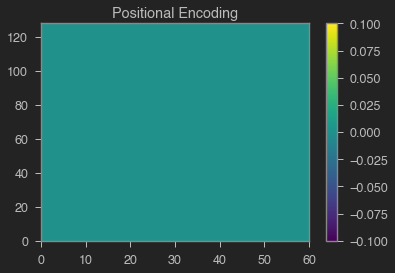

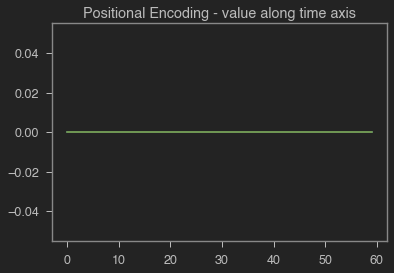

In [ ]:
model.show_pe()

In [ ]:
#export
@delegates(TSTPlus.__init__)
class MultiTSTPlus(nn.Sequential):
    _arch = TSTPlus
    def __init__(self, feat_list, c_out, seq_len, max_seq_len:Optional[int]=512, custom_head=None, **kwargs):
        r"""
        MultiTST is a class that allows you to create a model with multiple branches of TST.
        
        Args:
            * feat_list: list with number of features that will be passed to each body.
        """
        self.feat_list = [feat_list] if isinstance(feat_list, int) else feat_list 
        self.device = ifnone(device, default_device())
        
        # Backbone
        branches = nn.ModuleList()
        self.head_nf = 0
        for feat in self.feat_list:
            m = build_ts_model(self._arch, c_in=feat, c_out=c_out, seq_len=seq_len, max_seq_len=max_seq_len, **kwargs)
            with torch.no_grad(): 
                self.head_nf += m[0](torch.randn(1, feat, ifnone(seq_len, 10)).to(self.device)).shape[1]
            branches.append(m.backbone)
        backbone = _Splitter(self.feat_list, branches)
        
        # Head
        self.c_out = c_out
        q_len = min(seq_len, max_seq_len)
        self.seq_len = q_len 
        if custom_head is None:
            head = self._arch.create_head(self, self.head_nf, c_out, q_len, **kwargs)
        else: 
            head = custom_head(self.head_nf, c_out, q_len, **kwargs)
    
        layers = OrderedDict([('backbone', nn.Sequential(backbone)), ('head', nn.Sequential(head))])
        super().__init__(layers)
        self.to(self.device)
    
    
class _Splitter(Module):
    def __init__(self, feat_list, branches):
        self.feat_list, self.branches = feat_list, branches
    def forward(self, x):
        x = torch.split(x, self.feat_list, dim=1)
        for i, branch in enumerate(self.branches):
            out = branch(x[i]) if i == 0 else torch.cat([out, branch(x[i])], dim=1)
        return out

In [ ]:
bs = 8
c_in = 7  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 10
xb2 = torch.randn(bs, c_in, seq_len)
model1 = MultiTSTPlus([2, 5], c_out, seq_len, )
model2 = MultiTSTPlus(7, c_out, seq_len)
test_eq(model1(xb2).shape, model2(xb2).shape)
test_eq(count_parameters(model1) > count_parameters(model2), True)

In [ ]:
model1 = MultiTSTPlus([2, 5], c_out, seq_len, y_range=(0.5, 5.5))
body, head = split_model(model1)
test_eq(body(xb2).ndim, 3)
test_eq(head(body(xb2)).ndim, 2)
head

Sequential(
  (0): Sequential(
    (0): Flatten(full=False)
    (1): LinBnDrop(
      (0): Linear(in_features=2560, out_features=2, bias=True)
    )
    (2): SigmoidRange(low=0.5, high=5.5)
  )
)

In [ ]:
bs = 8
n_vars = 3
seq_len = 12
c_out = 2
xb = torch.rand(bs, n_vars, seq_len)
net = MultiTSTPlus(n_vars, c_out, seq_len)
change_model_head(net, create_pool_plus_head, concat_pool=False)
print(net(xb).shape)
net.head

torch.Size([8, 2])


Sequential(
  (0): AdaptiveAvgPool1d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
bs = 8
n_vars = 3
seq_len = 12
c_out = 2
xb = torch.rand(bs, n_vars, seq_len)
new_head = partial(conv_lin_3d_head, d=5)
net = MultiTSTPlus(n_vars, c_out, seq_len, custom_head=new_head)
print(net(xb).shape)
net.head

torch.Size([8, 2, 5])


Sequential(
  (0): create_conv_lin_3d_head(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv1d(128, 2, kernel_size=(1,), stride=(1,), bias=False)
    (2): Transpose(-1, -2)
    (3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Transpose(-1, -2)
    (5): Linear(in_features=12, out_features=5, bias=False)
  )
)

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 008b_tslearner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.MVP.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_model